In [4]:
# LIBRARIES


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn import datasets



# Visualisation Optiions

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# 1.DATASET 
about this Dataset

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

source: Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK.

Citation:
Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197â€“208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17).

In [5]:
# Read the file

df = pd.read_csv('/Users/dv/Desktop/Online Retail.csv')


In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


 we have 8 columns of data for each row and each row represents an item purchased.

In [7]:
df.shape


(541909, 8)

In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# 2. DATA CLEANUP AND CREATING SOME AD-HOC DIMENSIONS

In [9]:
# Drop cancelled orders
df = df.loc[df['Quantity'] > 0]

# Drop records without CustomerID
df = df[pd.notnull(df['CustomerID'])]

# Drop incomplete month
df = df.loc[df['InvoiceDate'] < '2011-12-01']

# Calculate total sales from the Quantity and UnitPrice
df['Sales'] = df['Quantity'] * df['UnitPrice']

In [10]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/11 12:50,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France,16.60
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/11 12:50,4.95,12680.0,France,14.85


In [11]:
# use groupby to aggregate sales by CustomerID
customer_df = df.groupby('CustomerID').agg({'Sales': sum, 
                                            'InvoiceNo': lambda x: x.nunique()})

# Select the columns we want to use
customer_df.columns = ['TotalSales', 'OrderCount'] 

# create a new column 'AvgOrderValu'
customer_df['AvgOrderValue'] = customer_df['TotalSales'] / customer_df['OrderCount']

customer_df.head()

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.60
12347.0,2706.32,4,676.58
12348.0,1120.24,2,560.12
12349.0,1757.55,1,1757.55
12350.0,334.40,1,334.40


We now have a DataFrame with total sales, order count, and average order value for each customer

# 3. STANDARISATION

Standardization refers to shifting the distribution of each attribute to have a mean of zero and a standard deviation 
of one (unit variance). This way we guarantee that the units of measurments are not giving more or less weight to any
of the features.
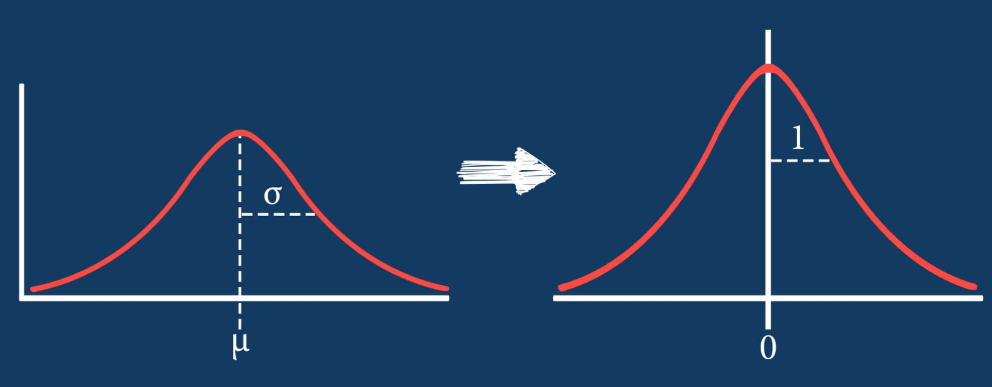


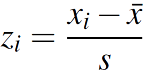

In [12]:
rank_df = customer_df.rank(method='first')
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()
normalized_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.728056,-1.731252,1.730186
12347.0,1.469167,1.038751,1.366890
12348.0,0.904512,-0.101212,1.211344
12349.0,1.247567,-1.730186,1.676917
12350.0,-0.504993,-1.729121,0.365427
12352.0,0.250366,-0.100146,0.099081
12356.0,1.403113,-0.099081,1.612994
12357.0,1.649217,-1.728056,1.728056
12358.0,0.398454,-1.726990,1.378609


In [13]:
normalized_df.describe()

,TotalSales,OrderCount,AvgOrderValue
count,3251.000000,3.251000e+03,3251.000000
mean,0.000000,1.748490e-17,0.000000
std,1.000000,1.000000e+00,1.000000
min,-1.731252,-1.731252e+00,-1.731252
25%,-0.865626,-8.656259e-01,-0.865626
50%,0.000000,0.000000e+00,0.000000
75%,0.865626,8.656259e-01,0.865626
max,1.731252,1.731252e+00,1.731252


# 4. SELECT RIGHT NUMBER OF CLUSTERS



Alright, we’re ready to run cluster analysis. But first, we need to figure out how many clusters we want to use. There are several approaches to selecting the number of clusters to use, but I’m going to cover two in this article:

(1) the elbow method 

(2) silhouette coefficient


# 4.1 The Elbow Method with the Sum of Squared Errors (SSE)

array([0, 0, 0, ..., 1, 0, 0], dtype=int32)

array([0, 2, 2, ..., 1, 2, 2], dtype=int32)

array([0, 1, 1, ..., 3, 2, 1], dtype=int32)

array([3, 1, 3, ..., 2, 4, 1], dtype=int32)

array([3, 5, 3, ..., 4, 2, 5], dtype=int32)

array([0, 5, 3, ..., 2, 1, 5], dtype=int32)

array([7, 4, 1, ..., 5, 3, 1], dtype=int32)

array([3, 6, 0, ..., 1, 5, 0], dtype=int32)

array([3, 4, 2, ..., 8, 1, 2], dtype=int32)

Text(0.5, 0, '$K$')

Text(0, 0.5, 'Sum of Squares')

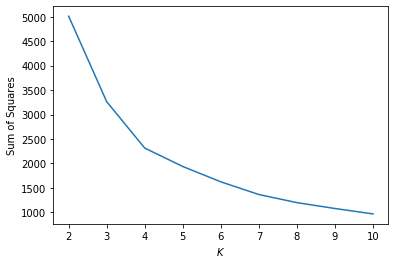

In [14]:
from sklearn import cluster
import numpy as np

sse = []
krange = list(range(2,11))
X = normalized_df[['TotalSales','OrderCount','AvgOrderValue']].values
for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=3)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    sse.append(np.sum((X - centers[cluster_assignments]) ** 2))

plt.plot(krange, sse)
plt.xlabel("$K$")
plt.ylabel("Sum of Squares")
plt.show()

# 4.1 Silhouette coefficient

In [15]:
# Use silhouette coefficient to determine the best number of clusters
from sklearn.metrics import silhouette_score

for n_cluster in [3,4,5,6,7,8,9,10]:
    kmeans = KMeans(n_clusters=n_cluster).fit(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])
    
    silhouette_avg = silhouette_score(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']], 
        kmeans.labels_)
    
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

Silhouette Score for 3 Clusters: 0.4187
Silhouette Score for 4 Clusters: 0.4212
Silhouette Score for 5 Clusters: 0.3824
Silhouette Score for 6 Clusters: 0.3666
Silhouette Score for 7 Clusters: 0.3860
Silhouette Score for 8 Clusters: 0.3644
Silhouette Score for 9 Clusters: 0.3575
Silhouette Score for 10 Clusters: 0.3495


For n_clusters = 3 The average silhouette_score is : 0.41884137425172513
For n_clusters = 4 The average silhouette_score is : 0.42120437523237747
For n_clusters = 5 The average silhouette_score is : 0.3824480951505352
For n_clusters = 6 The average silhouette_score is : 0.3666097216863904


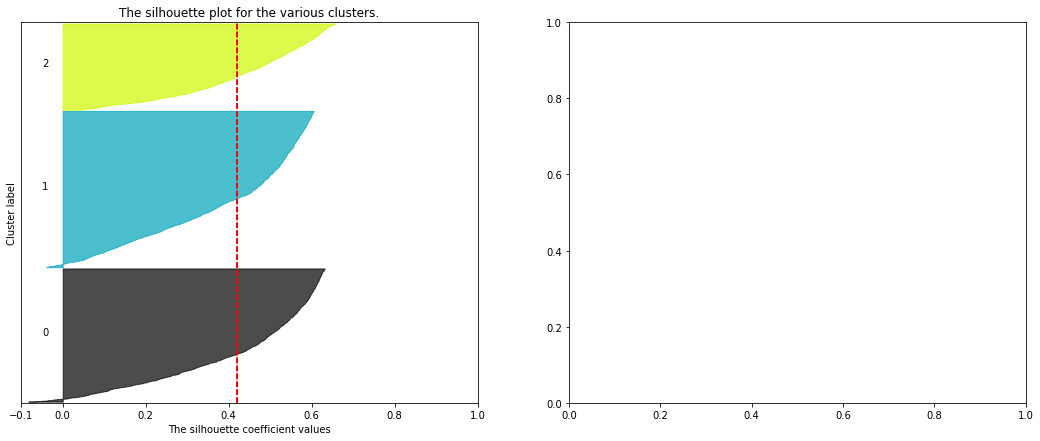

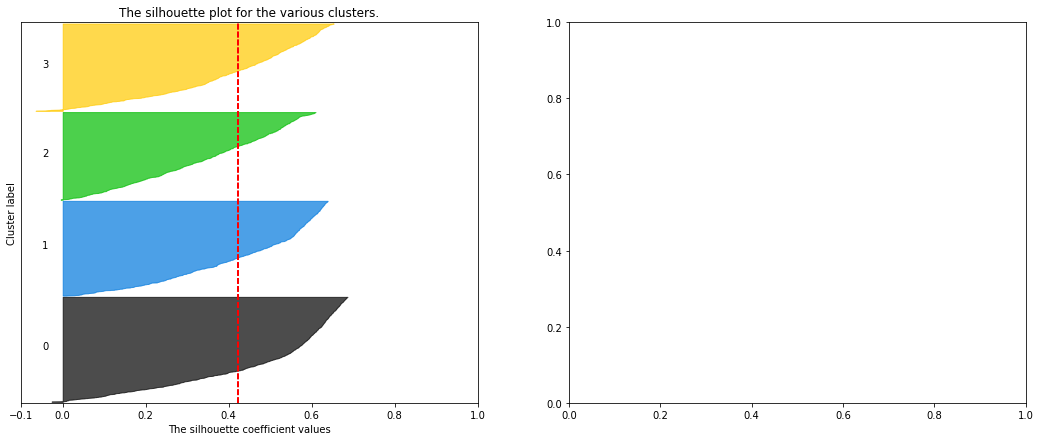

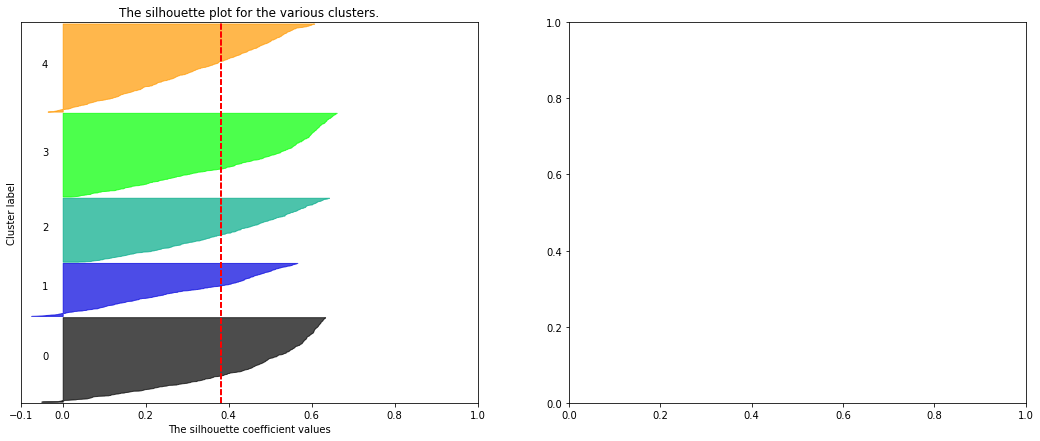

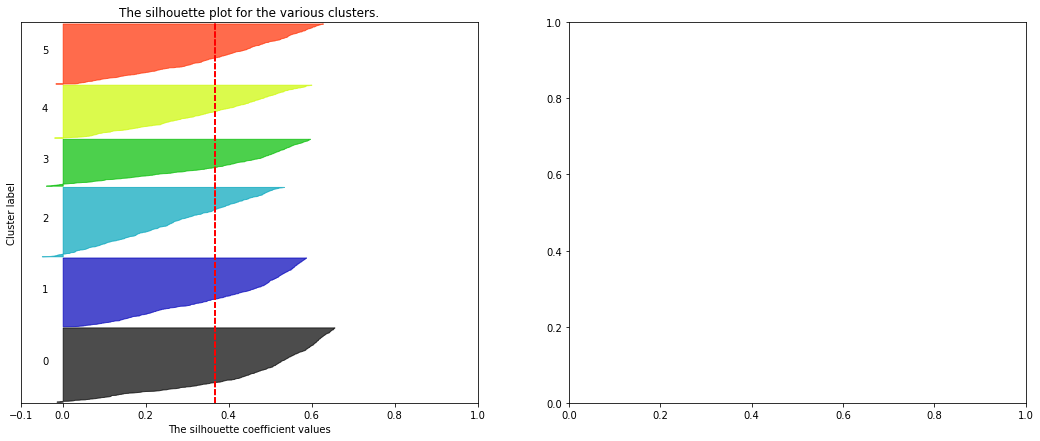

In [16]:


#Silhouette coefficients near +1 indicate that the sample is far away from the
#neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision 
#boundary between two neighboring clusters and negative values indicate that those samples 
#might have been assigned to the wrong cluster.
#
#Avg Silhouette score: I get the average Silhouette score of the cluster k.
#Silhouette samples score: And, for all the samples belonging to a given cluster 
#(from 1 to k), I calculate the individual silhouette score of each sample belong 
#to that cluster.

# Important #

#Negative values means that they are not in the right cluster since they might
#be closer to other centroids from other clusters. 

#Then I sort the scores of all samples belonging to each cluster. 
#This is needed so that I can plot the score in an ascending order.

#s(i) = {b(i) - a(i)} / {\max\{a(i),b(i)\}}
#


#Explnation here https://www.youtube.com/watch?v=5TPldC_dC0s


range_n_clusters = [3,4,5,6]
scores=[]

def number_of_clusters_silhouette():
        
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
         
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(normalized_df) + (n_clusters + 1) * 10])
        
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(normalized_df)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(normalized_df, cluster_labels)
        scores.append(silhouette_avg)
        print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
#        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(normalized_df, cluster_labels)
        
#        If you want to see the values for each point of the dataset
#        print(sample_silhouette_values)
        
        y_lower = 10
        
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]
#    
            ith_cluster_silhouette_values.sort()
#    
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
#    
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
    
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
    
            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")
        
            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        
            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
           
        
number_of_clusters_silhouette()

# 5. RUNNING CLUSTERING

In [17]:
kmeans = KMeans(n_clusters=4).fit(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])

four_cluster_df = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_

four_cluster_df.head(15)

,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.728056,-1.731252,1.730186,0
12347.0,1.469167,1.038751,1.366890,2
12348.0,0.904512,-0.101212,1.211344,2
12349.0,1.247567,-1.730186,1.676917,0
12350.0,-0.504993,-1.729121,0.365427,0
12352.0,0.250366,-0.100146,0.099081,3
12356.0,1.403113,-0.099081,1.612994,2
12357.0,1.649217,-1.728056,1.728056,0
12358.0,0.398454,-1.726990,1.378609,0


# 6. INTERPRETING CUSTOMER SEGMENTS

In [65]:
cluster1_metrics = kmeans.cluster_centers_[0]
cluster2_metrics = kmeans.cluster_centers_[1]
cluster3_metrics = kmeans.cluster_centers_[2]
cluster4_metrics = kmeans.cluster_centers_[3]

data = [cluster1_metrics, cluster2_metrics, cluster3_metrics, cluster4_metrics]
cluster_center_df = pd.DataFrame(data)

cluster_center_df.columns = four_cluster_df.columns[0:3]
cluster_center_df

,TotalSales,OrderCount,AvgOrderValue
0,1.200580,0.949028,0.935311
1,-1.243376,-0.721740,-1.045310
2,-0.045426,-0.938479,0.814395
3,0.232106,0.773302,-0.576379


Text(0.5, 1.0, 'TotalSales vs. OrderCount Clusters')

Text(0.5, 0, 'Order Count')

Text(0, 0.5, 'Total Sales')

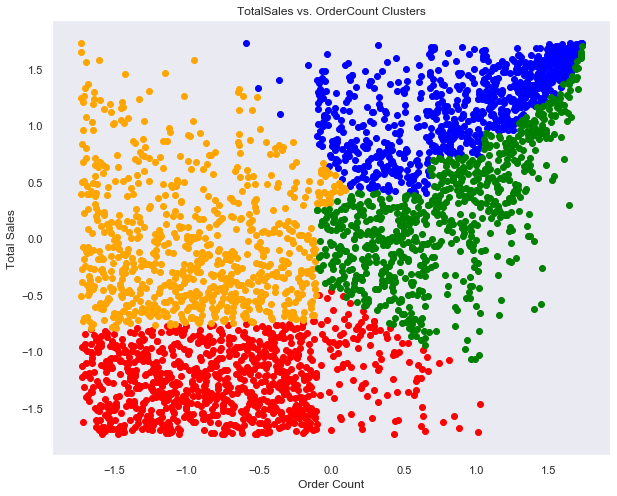

Text(0.5, 1.0, 'AvgOrderValue vs. OrderCount Clusters')

Text(0.5, 0, 'Order Count')

Text(0, 0.5, 'Avg Order Value')

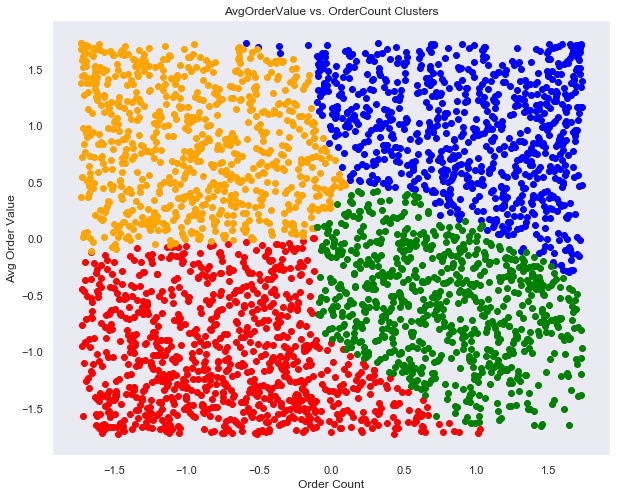

In [66]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
    c='blue')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
    c='red')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
    c='orange')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
    c='green')

plt.title('TotalSales vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')

plt.grid()
plt.show()


plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='blue')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='red')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='orange')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='green')

plt.title('AvgOrderValue vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Avg Order Value')

plt.grid()
plt.show()



Text(0.5, 1.0, 'AvgOrderValue vs. TotalSales Clusters')

Text(0.5, 0, 'Total Sales')

Text(0, 0.5, 'Avg Order Value')

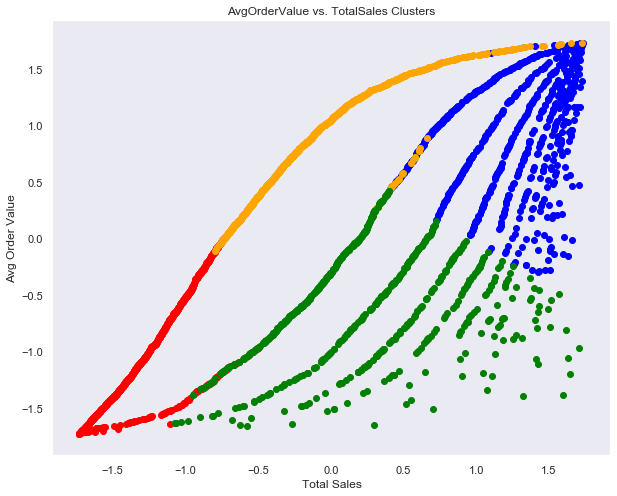

In [67]:
plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
    c='blue')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
    c='red')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
    c='orange')

plt.scatter(
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'], 
    four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
    c='green')

plt.title('AvgOrderValue vs. TotalSales Clusters')
plt.xlabel('Total Sales')
plt.ylabel('Avg Order Value')



plt.grid()
plt.show()


# 6. Find the best-selling item by cluster. Recommendation

In [24]:
high_value_cluster = four_cluster_df.loc[four_cluster_df['Cluster'] == 2]

pd.DataFrame(df.loc[df['CustomerID'].isin(high_value_cluster.index)].groupby(
    'Description').count()['StockCode'].sort_values(ascending=False).head())

,StockCode
Description,
WHITE HANGING HEART T-LIGHT HOLDER,467
REGENCY CAKESTAND 3 TIER,440
PAPER CHAIN KIT 50'S CHRISTMAS,424
JUMBO BAG RED RETROSPOT,410
RABBIT NIGHT LIGHT,343
